## Select closest points using CKDTree

To select closest grid points, we will use here one approach using [cKDTree](http://docs.scipy.org/doc/scipy-0.12.0/reference/generated/scipy.spatial.cKDTree.html) class from scipy.spatial package.

Two methods of interpolation are considered here: nearest neighbour and weighting with the inverse of distance squared:

$T_t = frac{\\sum_{i=1}^{m}T_{s,i}w_i}{\\sum_{i=1}^{m}w_i}$, $w_i = 1/d_i^2$).


In [1]:
#for Netcdf manipulation
import xarray as xr

#for array manipulation
import numpy as np
import pandas as pd

#for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt

#for interpolation
from scipy.spatial import cKDTree

D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


First we load Netcdf data.

In [2]:
unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_FWI_Netcdf/ERA5_FWI_QC_SNOW_New_2018_from_4_to_8.nc'
TAS = xr.open_dataset(unique_dataDIR)

In [3]:
lon2d, lat2d = np.meshgrid(TAS.lon, TAS.lat)

In [4]:
class KDTreeIndex():
    
    """ A KD-tree implementation for fast point lookup on a 2D grid
    
    Keyword arguments: 
    dataset -- a xarray DataArray containing lat/lon coordinates
               (named 'lat' and 'lon' respectively)
               
    """
    
    def transform_coordinates(self, coords):
        """ Transform coordinates from geodetic to cartesian
        
        Keyword arguments:
        coords - a set of lan/lon coordinates (e.g. a tuple or 
                 an array of tuples)
        """
        # WGS 84 reference coordinate system parameters
        A = 6378.137 # major axis [km]   
        E2 = 6.69437999014e-3 # eccentricity squared    
        
        coords = np.asarray(coords).astype(np.float)
        
        # is coords a tuple? Convert it to an one-element array of tuples
        if coords.ndim == 1:
            coords = np.array([coords])
        
        # convert to radiants
        lat_rad = np.radians(coords[:,0])
        lon_rad = np.radians(coords[:,1]) 
        
        # convert to cartesian coordinates
        r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
        x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
        y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
        z = r_n * (1 - E2) * np.sin(lat_rad)
        
        return np.column_stack((x, y, z))
    
    def __init__(self, dataset):
        # store original dataset shape
        self.shape = dataset.shape
        lon2d, lat2d = np.meshgrid(dataset.lon, dataset.lat)
        # reshape and stack coordinates
        coords = np.column_stack((lat2d.ravel(),
                                  lon2d.ravel()))
        
        # construct KD-tree
        self.tree = cKDTree(self.transform_coordinates(coords))
        
    def query(self, point, k):
        """ Query the kd-tree for nearest neighbour.

        Keyword arguments:
        point -- a (lat, lon) tuple or array of tuples
        """
        d, inds  = self.tree.query(self.transform_coordinates(point),k=k)
        w = 1.0 / d**2
        # regrid to 2D grid
        indslatlon = np.unravel_index(inds, self.shape)
        # return DataArray indexers
        return d, inds, w, indslatlon
       # return xr.DataArray(index[0], dims='pixel'), \
       #        xr.DataArray(index[1], dims='pixel')

In [5]:
ground_pixel_tree = KDTreeIndex(TAS.sel(time='2018-08-01').FWI)

In [6]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_shapefile_2018.csv", sep=",")
stations.head()

,NoStation,latD,lonD
0,472,49.2592,-68.1461
1,474,49.6472,-67.6264
2,475,49.1956,-69.4128
3,614,49.3594,-70.9153
4,615,49.6058,-70.1111


## Working with one station

Select k=10closest points:

In [7]:
site = stations['latD'][0], stations['lonD'][0]
d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)
print(d)
print(w)
print(inds)
print(indslatlon)

[[ 7.63261321 10.68490269 25.78351918 27.82346772 28.80577838 28.85342061
  29.80683574 30.73498972 37.11616898 38.70448708]]
[[0.01716538 0.00875909 0.00150423 0.00129175 0.00120515 0.00120117
  0.00112556 0.0010586  0.00072589 0.00066754]]
[[6234 6235 6233 6113 6114 6236 6355 6356 6112 6354]]
(array([[51, 51, 51, 50, 50, 51, 52, 52, 50, 52]], dtype=int64), array([[63, 64, 62, 63, 64, 65, 63, 64, 62, 62]], dtype=int64))


Loop over each day from our dataset: 

In [8]:
FWI_kpts = []
FWI_kpts_model = pd.DataFrame()
i=1
for day in TAS.time: 
    FWI_kpts.append((np.nansum(w * TAS.sel(time=day).FWI.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0])
FWI_kpts_model[str(i)] = FWI_kpts
FWI_kpts_model['Date'] = TAS.time
FWI_kpts_model = FWI_kpts_model.set_index('Date')
FWI_kpts_model.tail()

,1
Date,
2018-08-27,0.463228
2018-08-28,1.609895
2018-08-29,0.687801
2018-08-30,0.224681
2018-08-31,0.495154


## Loop over all stations using stations' index

In [9]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_shapefile_2018.csv", sep=",")
FWI_kpts_model = pd.DataFrame()
for i, row in stations.iterrows(): 
    site = row['latD'], row['lonD']
    d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)
    FWI_kpts = []    
    for day in TAS.time: 
        FWI_kpts.append((np.nansum(w * TAS.sel(time=day).FWI.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0])
    FWI_kpts_model[str(int(row[0]))] = FWI_kpts
    
FWI_kpts_model['Date'] = TAS.time
FWI_kpts_model = FWI_kpts_model.set_index('Date')
FWI_kpts_model.to_csv("K:/PROJETS/PROJET_FIRE_INDEX/Closest_points/FWI_kpts_model_Shapefile_2018.csv", header = True, sep = ',') 
FWI_kpts_model.tail()

,472,474,475,614,615,621,622,623,632,644,...,669,735,736,747,752,754,763,764,765,766
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-27,0.463228,1.037289,2.313211,0.420880,0.601124,1.162417,0.899486,1.671296,0.220524,0.663491,...,0.183825,1.961336,0.648735,0.159995,1.188207,0.495140,0.095541,0.345484,0.380397,0.617105
2018-08-28,1.609895,3.531019,6.245470,1.176978,1.237254,2.766669,2.418583,4.035269,0.349756,1.869325,...,0.443032,0.049807,0.173053,0.624639,0.019839,0.390742,0.401487,0.498875,0.436976,0.163298
2018-08-29,0.687801,0.876227,0.215188,0.001097,0.006254,0.043068,0.212332,0.271567,0.000943,0.204582,...,0.006077,0.007761,0.027810,0.022200,0.002671,0.009535,0.008947,0.010303,0.003542,0.010339
2018-08-30,0.224681,0.559727,0.427009,0.032597,0.073205,0.209163,0.330928,0.405790,0.054804,0.414036,...,0.083510,0.083862,0.161333,0.202345,0.012883,0.072379,0.140696,0.125686,0.043194,0.075453
2018-08-31,0.495154,1.131096,0.887246,0.391168,0.439906,0.610205,0.670110,0.780303,0.413709,0.741472,...,0.434266,1.248801,0.879788,0.622335,0.742063,0.594267,0.497122,0.522386,0.532600,0.667395


## Open FWI computed over stations 

In [10]:
dataframe = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_In_curr_Shapefile_FWI_SOPFEU2018.csv", encoding='latin-1')
dataframe = dataframe.set_index('Date')
dataframe.head()

,472,474,475,614,615,621,622,623,632,644,...,669,735,736,747,752,754,763,764,765,766
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-01,0.0,5.9,6.1,0.0,0.0,0.5,1.0,6.0,4.2,0.0,...,5.6,4.2,4.1,3.5,4.3,6.0,2.0,5.3,0.0,7.5
2018-04-02,0.4,14.8,4.4,0.0,0.1,0.8,1.0,5.3,7.7,0.2,...,0.2,0.3,3.3,0.9,3.1,3.5,0.4,0.8,0.0,0.7
2018-04-03,0.6,14.8,4.8,0.2,0.3,0.9,2.2,14.4,9.4,0.2,...,0.5,0.6,5.1,1.6,2.9,3.0,0.7,2.3,0.4,0.9
2018-04-04,0.8,11.7,5.6,0.2,0.1,0.9,2.3,7.9,12.8,0.2,...,0.1,0.5,4.4,1.8,3.7,1.0,0.9,3.0,0.8,0.0
2018-04-05,1.8,9.3,0.0,0.0,0.0,0.0,0.0,8.5,7.2,0.0,...,0.0,0.4,0.1,0.0,2.0,0.0,0.0,0.3,0.8,0.0


In [11]:
FWI_stations_ERA5 = pd.DataFrame()
for ind in dataframe.columns:
    FWI_stations_ERA5['station_'+str(ind)] = dataframe[ind].values
    FWI_stations_ERA5['ERA5_'+str(ind)] = FWI_kpts_model[ind].values
FWI_stations_ERA5['Date'] = dataframe.index
FWI_stations_ERA5 = FWI_stations_ERA5.set_index('Date') 
FWI_stations_ERA5.head()

,station_472,ERA5_472,station_474,ERA5_474,station_475,ERA5_475,station_614,ERA5_614,station_615,ERA5_615,...,station_754,ERA5_754,station_763,ERA5_763,station_764,ERA5_764,station_765,ERA5_765,station_766,ERA5_766
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-01,0.0,0.0,5.9,0.0,6.1,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,2.0,0.0,5.3,0.0,0.0,0.0,7.5,0.0
2018-04-02,0.4,0.0,14.8,0.0,4.4,0.0,0.0,0.0,0.1,0.0,...,3.5,0.0,0.4,0.0,0.8,0.0,0.0,0.0,0.7,0.0
2018-04-03,0.6,0.0,14.8,0.0,4.8,0.0,0.2,0.0,0.3,0.0,...,3.0,0.0,0.7,0.0,2.3,0.0,0.4,0.0,0.9,0.0
2018-04-04,0.8,0.0,11.7,0.0,5.6,0.0,0.2,0.0,0.1,0.0,...,1.0,0.0,0.9,0.0,3.0,0.0,0.8,0.0,0.0,0.0
2018-04-05,1.8,0.0,9.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.3,0.0,0.8,0.0,0.0,0.0


In [12]:
FWI_stations_ERA5 = FWI_stations_ERA5.loc['2018-06-01':'2018-08-31']
len(FWI_stations_ERA5.columns)

54

In [13]:
i = 0
corr_stations_ERA5 = []
while (i < len(FWI_stations_ERA5.columns)-1): 
    corr_stations_ERA5.append(FWI_stations_ERA5.iloc[:,i].corr(FWI_stations_ERA5.iloc[:,i+1]))
    i+=2

In [14]:
df_corr_stations_ERA5 = pd.DataFrame()
df_corr_stations_ERA5['Correlation'] = corr_stations_ERA5
df_corr_stations_ERA5['Lat'] = stations.latD
df_corr_stations_ERA5['Lon'] = stations.lonD
df_corr_stations_ERA5.head()

,Correlation,Lat,Lon
0,0.174468,49.2592,-68.1461
1,0.064309,49.6472,-67.6264
2,-0.012829,49.1956,-69.4128
3,0.886546,49.3594,-70.9153
4,0.811121,49.6058,-70.1111


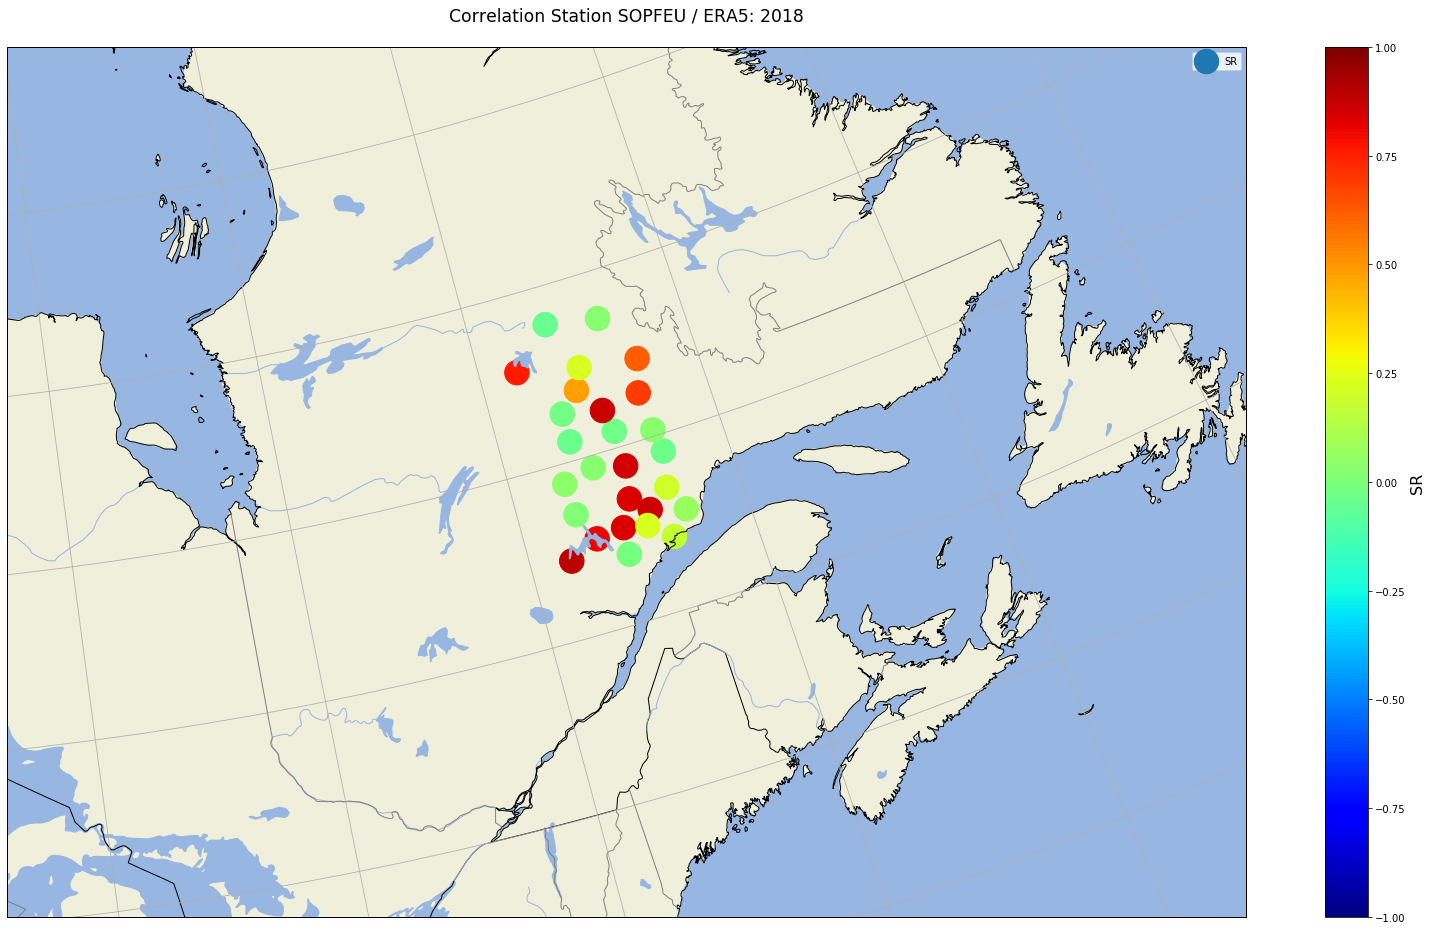

In [15]:
fig=plt.figure(figsize=(28,16), frameon=True) 
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-85,-55,45,55])
 #ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
  
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière
                            facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')   
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')
   
ax.add_feature(states_provinces, edgecolor='gray')
# Plots the data onto map
plt.scatter(df_corr_stations_ERA5['Lon'], df_corr_stations_ERA5['Lat'], alpha=1.,
            s=600, label="SR",
            c=df_corr_stations_ERA5['Correlation'],
            vmin=-1,
            vmax=1,
            cmap=plt.get_cmap("jet"),
            transform=ccrs.PlateCarree())
       
ax.gridlines()
# Colorbar
fwi = df_corr_stations_ERA5['Correlation']
#tick_values = np.linspace(fwi.min(), fwi.max(), 11)
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(["%d"%(v) for v in tick_values], fontsize=14)
cbar.set_label('SR', fontsize=16)
# Plot labels
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend()
 
string_title=u'Correlation Station SOPFEU / ERA5: 2018\n'
plt.title(string_title, size='xx-large')
plt.savefig('K:/PROJETS/PROJET_FIRE_INDEX/figures/SOPFEU_Stations_in_Shapefile_Correlation_2018.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [16]:
dataframe_stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_In_curr_Shapefile_FWI_SOPFEU2018.csv", encoding='latin-1')
dataframe_stations = dataframe_stations.set_index('Date')
dataframe_stations = dataframe_stations.loc['2018-06-01':'2018-08-31']
FWI_kpts_model = FWI_kpts_model.loc['2018-06-01':'2018-08-31']
dataframe_stations.head()

,472,474,475,614,615,621,622,623,632,644,...,669,735,736,747,752,754,763,764,765,766
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-01,3.1,0.0,2.4,0.1,4.1,10.2,10.5,3.8,29.0,4.0,...,0.0,0.6,6.8,10.5,0.1,5.1,0.8,1.1,9.8,0.0
2018-06-02,13.5,5.1,3.5,2.3,1.0,4.5,2.5,4.9,16.9,9.7,...,0.1,1.0,9.3,6.2,0.6,3.6,1.4,2.4,3.9,0.2
2018-06-03,3.6,0.3,16.7,5.5,4.2,7.1,2.7,0.4,0.0,9.0,...,0.0,0.0,0.1,2.9,0.9,4.3,3.5,2.1,0.4,0.4
2018-06-04,0.9,4.3,2.0,10.9,5.2,9.2,4.6,0.0,0.0,0.0,...,0.3,0.1,1.0,6.9,6.2,3.2,7.6,5.3,1.9,0.4
2018-06-05,4.1,5.6,3.5,0.0,0.0,0.1,1.7,0.1,0.7,0.0,...,0.8,1.6,1.9,8.4,10.7,2.9,9.1,4.9,4.4,0.6


In [17]:
df_corr_stations_ERA5.head()

,Correlation,Lat,Lon
0,0.174468,49.2592,-68.1461
1,0.064309,49.6472,-67.6264
2,-0.012829,49.1956,-69.4128
3,0.886546,49.3594,-70.9153
4,0.811121,49.6058,-70.1111


In [18]:
df2_corr_stations_ERA5 = pd.DataFrame()
df2_corr_stations_ERA5['Correlation'] = dataframe_stations.corrwith(other=FWI_kpts_model)
df2_corr_stations_ERA5['Lat'] = stations.latD.values
df2_corr_stations_ERA5['Lon'] = stations.lonD.values
df2_corr_stations_ERA5.head()

,Correlation,Lat,Lon
472,0.174468,49.2592,-68.1461
474,0.064309,49.6472,-67.6264
475,-0.012829,49.1956,-69.4128
614,0.886546,49.3594,-70.9153
615,0.811121,49.6058,-70.1111


Text(0, 0.5, 'FWI ERA5 closest point')

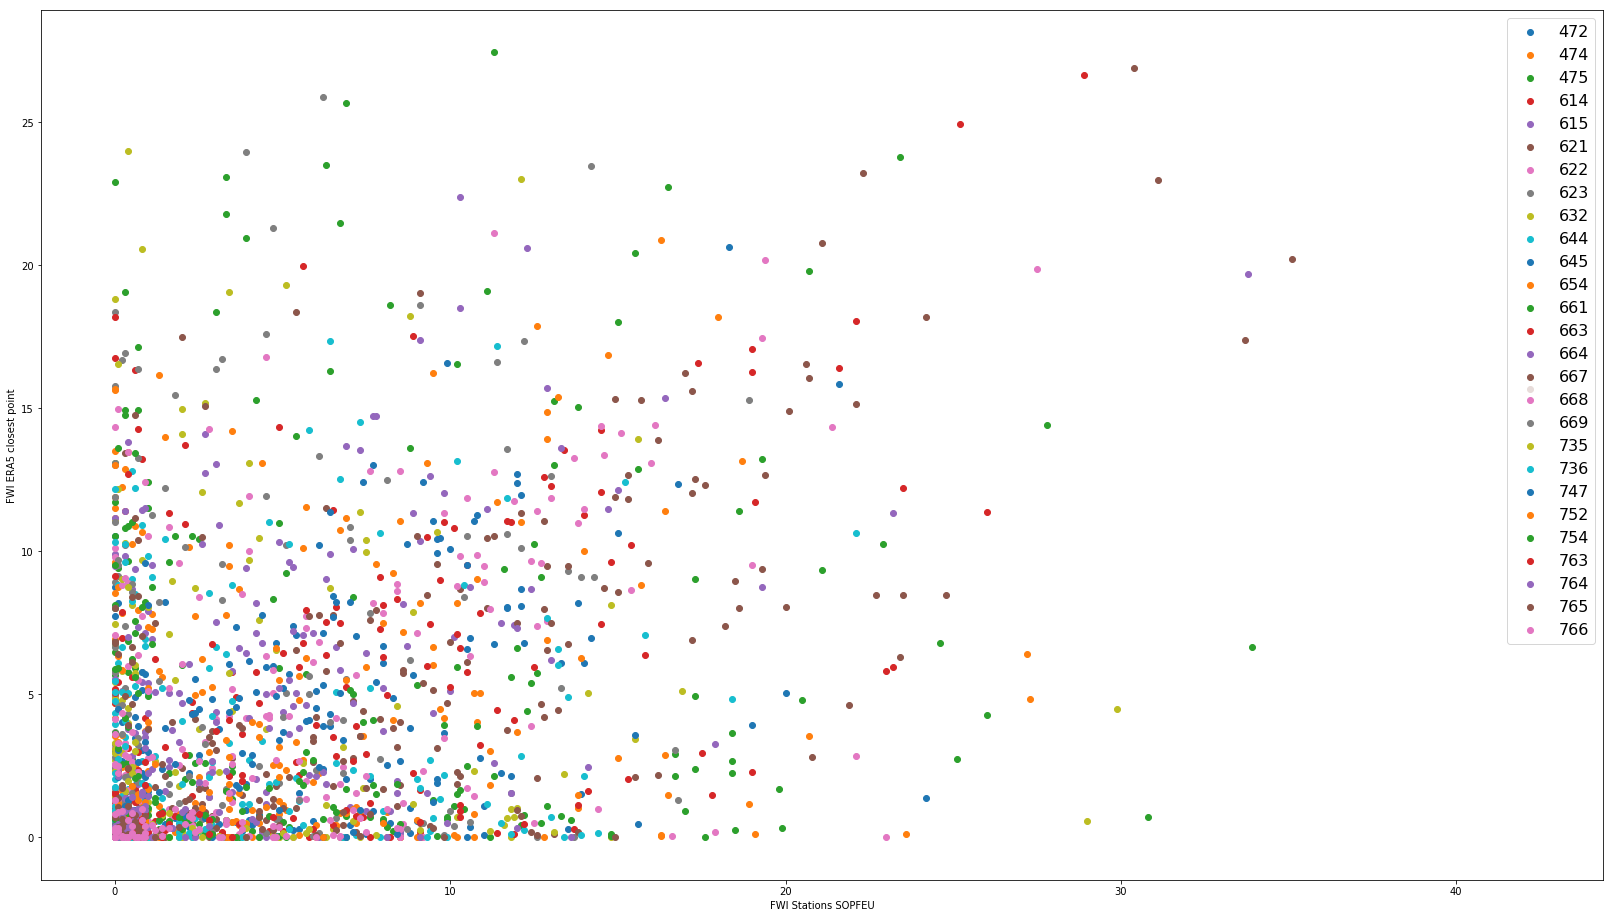

In [19]:
#dataframe_stations.corrwith(other=FWI_kpts_model)
fig=plt.figure(figsize=(28,16), frameon=True) 
for col in dataframe_stations.columns:
    plt.scatter(dataframe_stations[col], FWI_kpts_model[col], label=col)
plt.legend(loc='best', fontsize=16)
plt.xlabel('FWI Stations SOPFEU')
plt.ylabel('FWI ERA5 closest point')

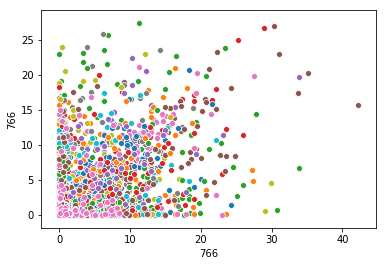

In [20]:
# library &amp; dataset
import seaborn as sns
# plot
for col in dataframe_stations.columns:
    sns.scatterplot(x=dataframe_stations[col], y=FWI_kpts_model[col])


In [75]:
col

'766'